In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import time
import pyarrow
import gc
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import tqdm

# Model & Evaluation
from functools import partial
from sklearn import svm
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("input/covtype.csv")
encoder = LabelEncoder()
df["Cover_Type"] = encoder.fit_transform(df["Cover_Type"])
df["Soil_Type"] = 0
for i in range(1, 41):
    df["Soil_Type"] += i * df[f"Soil_Type{i}"]
df["Wilderness_Area"] = 0
for i in range(1, 5):
    df["Wilderness_Area"] += i * df[f"Wilderness_Area{i}"]
df.drop(columns=[f"Soil_Type{i}" for i in range(1, 41)] + [f"Wilderness_Area{i}" for i in range(1, 5)], inplace=True)
df_min = df.sample(n=10000, random_state=1)
df_min

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
376969,2949,101,21,693,151,3009,250,206,74,595,1,10,3
59897,3198,156,10,510,23,3900,232,241,140,4221,0,29,1
247100,2199,2,18,323,78,540,193,204,147,150,5,10,4
111532,2851,111,14,150,27,2394,243,224,107,2290,1,29,1
522294,2920,47,21,335,119,2292,222,189,92,2059,0,33,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
280470,2895,308,22,120,27,1020,155,220,203,807,1,23,3
169492,3290,30,9,720,29,3755,218,220,137,3869,0,38,1
74754,2732,161,9,180,9,1894,230,242,144,1124,1,12,1
56964,3011,0,3,812,39,5754,215,234,156,6276,0,29,1


c:\Users\yohan.chalier\venv\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


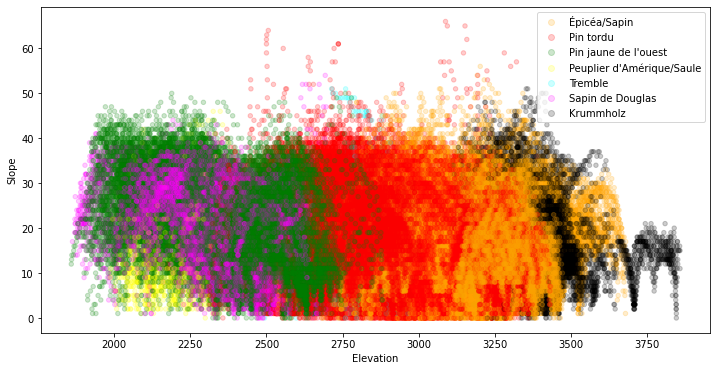

In [3]:
def scatter_plot(data_frame, feature_x, feature_y):
    fig, ax = plt.subplots(figsize=(12, 6))
    scatter = ax.scatter(
        data_frame[feature_x],
        data_frame[feature_y],
        c=data_frame["Cover_Type"],
        alpha=0.2,
        s=20,
        cmap=ListedColormap([
            "orange",
            "red",
            "green",
            "blue",
            "yellow",
            "cyan",
            "magenta",
            "black"
        ]))
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(handles=scatter.legend_elements()[0], labels=[
        "Épicéa/Sapin",
        "Pin tordu",
        "Pin jaune de l'ouest",
        "Peuplier d'Amérique/Saule",
        "Tremble",
        "Sapin de Douglas",
        "Krummholz"
    ])

scatter_plot(df, "Elevation", "Slope")

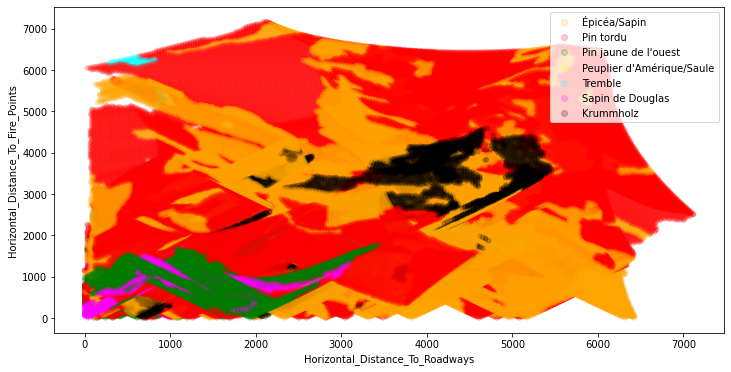

In [4]:
scatter_plot(df, "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points")

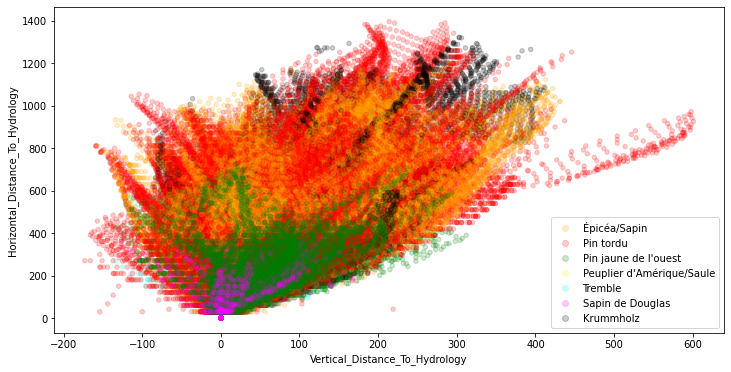

In [5]:
scatter_plot(df, "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Hydrology")

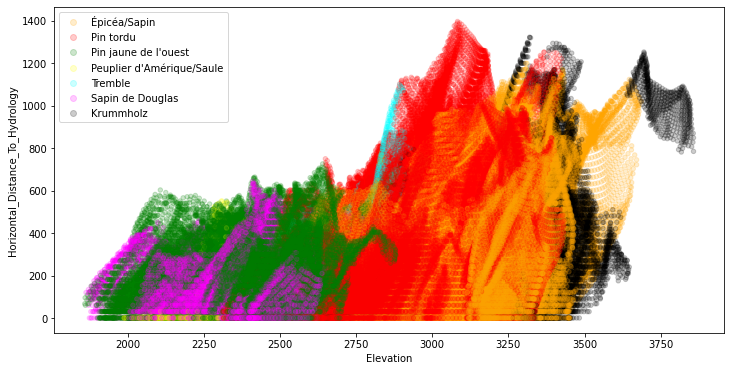

In [6]:
scatter_plot(df, "Elevation", "Horizontal_Distance_To_Hydrology")

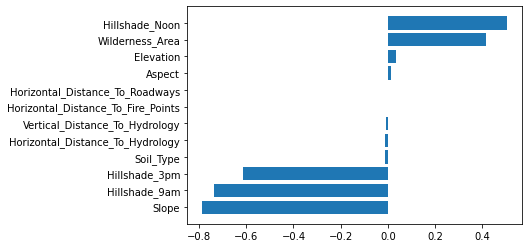

In [7]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

svm = svm.SVC(kernel='linear')
X, Y = df_min.drop(columns=["Cover_Type"])[:200], df_min["Cover_Type"][:200]
svm.fit(X, Y)
f_importances(svm.coef_[0], X.columns)

In [8]:
df2 = pd.concat(
    objs=[df[df["Cover_Type"].isin([0])].sample(n=100), df[df["Cover_Type"].isin([5])].sample(n=100)],
    axis=0).sample(frac=1)
df2.groupby(by="Cover_Type")["Cover_Type"].count()

Cover_Type
0    100
5    100
Name: Cover_Type, dtype: int64

In [9]:
feature_names = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

scores = dict()

for i, feature_x in enumerate(tqdm.tqdm(feature_names)):
    for j, feature_y in enumerate(feature_names):
        if i <= j:
            continue
        X = df2[[feature_x, feature_y]]
        scaler = StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        y = df2["Cover_Type"]
        clf = Perceptron()
        # clf = MLPClassifier(hidden_layer_sizes=(8,), max_iter=5000)
        clf.fit(X_scaled, y)
        gap = abs(clf.coef_[0,0] - clf.coef_[0,1])
        scores[(feature_x, feature_y)] = clf.score(X_scaled, y) / gap ** .2

print("Minimum score:", *min(scores.items(), key=lambda x: x[1]))
print("Maximum score:", *max(scores.items(), key=lambda x: x[1]))

100%|██████████| 10/10 [00:00<00:00, 82.97it/s]

Minimum score: ('Hillshade_3pm', 'Aspect') 0.44074346680325055
Maximum score: ('Horizontal_Distance_To_Fire_Points', 'Hillshade_3pm') 1.5193090710420927


0.805


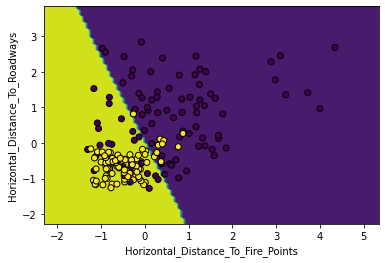

In [10]:
feature_x = "Horizontal_Distance_To_Fire_Points"
feature_y = "Horizontal_Distance_To_Roadways"
X = df2[[feature_x, feature_y]]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y = df2["Cover_Type"]
clf = Perceptron()
# clf = MLPClassifier(hidden_layer_sizes=(2,), max_iter=5000)
clf.fit(X_scaled, y)
print(clf.score(X_scaled, y))
disp = DecisionBoundaryDisplay.from_estimator(clf, X_scaled, response_method="predict")
disp.ax_.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df2["Cover_Type"], edgecolors="k")
disp.ax_.set_xlabel(feature_x)
disp.ax_.set_ylabel(feature_y)
pass

In [4]:
from sklearn import tree

In [11]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(df_min.drop(columns=["Cover_Type"]), df_min["Cover_Type"])

DecisionTreeClassifier(max_depth=5)

In [12]:
clf.score(df_min.drop(columns=["Cover_Type"]), df_min["Cover_Type"])

0.7177

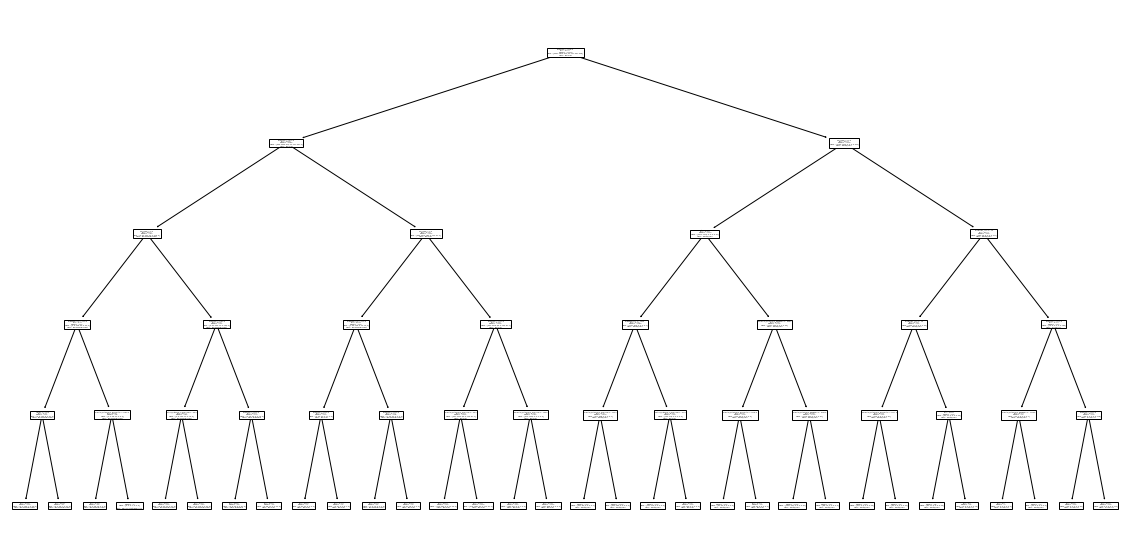

In [19]:
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=df_min.drop(columns=["Cover_Type"]).columns, class_names=["Épicéa/Sapin", "Pin tordu", "Pin jaune de l'ouest", "Peuplier d'Amérique/Saule", "Tremble", "Sapin de Douglas", "Krummholz"])
plt.savefig("tree.svg")
pass